#  <center> Taller  de Aprendizaje Automático </center>
##  <center> Taller 7: Gatos y Perros  </center>

Con el resurgimiento de las redes convolucionales en 2012, entre otras cosas gracias a la viabilidad de entrenar con millones de imágenes, una serie de problemas considerados muy difíciles o inabordables hasta entonces debido a la necesidad de generar algoritmos muy específicos para cada tarea  pasaron a estar al alcance de cualquier desarrollador. Un ejemplo emblemático es el de distinguir entre imágenes de perros y gatos. Debido a la gran variabilidad intra clase de estos animales, es realmente dificil generar características que permitan separar bien las clases y probablemente el esfuerzo que conlleva generar características específicas, no esté justificado por la relevancia del problema. En este taller se verá el procedimiento para entrenar un clasificador a partir de un número no muy grande de imágenes, sin necesidad de diseñar características.

## Objetivos

 - Familiarizarse con la estructura *Dataset* de tensorflow 
 - Aprender a utilizar modelos de clasificación de imágenes preentrenados en *tensorflow* con imágenes de *Imagenet* 
 - Conocer las opciones para realizar *aumento de datos* y aplicárselo a las imágenes de perros y gatos
 - Realizar *transferencia de aprendizaje* del modelo preentrenado con *Imagenet* al problema de clasificar perros y gatos
 - Explicar en base a qué regiones de una imagen el clasificador toma la decisión 

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/TAA-fing/TAA-2025/blob/main/talleres/taller7_gatos_y_perros.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
</table>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("¡GPU detectada y lista para usar!")
else:
    print("GPU NO detectada.")


¡GPU detectada y lista para usar!


## Parte 0 - Utilización de GPU

El entrenamiento de redes convolucionales en general es más rápido cuando se utiliza GPU (Graphic Processor Unit). Correr la siguiente celda y verificar que se está utilizando una. Debería observar un mensaje similar al siguiente:

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

En caso de no observar dicho mensaje y estar trabajando en Colab, verifique que el entorno de ejecución es el correcto, vaya a:  
Entorno de ejecuccióón-->Cambiar tipo de entorno de ejecución-->GPU

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Parte 1 - Levantar los datos

Se trabajará con los datos disponibles en [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview). En caso de estar trabajando en Colab seguir los siguientes pasos:

a) Installar el paquete *kaggle* para acceder a los datos 

b) Realizar la configuración necesaria para obtener datos desde la plataforma Kaggle.

### Configuración para trabajar en Colab

Ir a la página de la competencia y en la sección *data* aceptar los términos. Luego ejecutar la siguiente celda y pasarle el *token* de su usuario (ver comentario en celda).

In [5]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# El archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

ModuleNotFoundError: No module named 'google.colab'

Una vez guardado el *token* se pueden descargar los datos.

In [ ]:
# celda para bajar los datos desde colab
!kaggle competitions download -c dogs-vs-cats
!unzip /content/dogs-vs-cats.zip
!unzip /content/train.zip
!unzip /content/test1.zip

### Configuración para trabajar local

En caso de estar trabajando localmente ejecutar la siguiente celda.

In [5]:
pip install kaggle

  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ---------- ----------------------------- 1/4 [tqdm]
   ------------------------------ --------- 3/4 [kaggle]
   ------------------------------ --------- 3/4 [kaggle]
   ------------------------------ --------- 3/4 [kaggle]
   ------------------------------ --------- 3/4 [kaggle]
   ---------------------------------------- 4/4 [kaggle]

Note: you may need to restart the kernel to use updated packages.


In [7]:
# celda para bajar los datos localmente

!unzip train.zip
!unzip test1.zip

Archive:  train.zip
   creating: train/                
  inflating: train/cat.0.jpg         
  inflating: train/cat.1.jpg         
  inflating: train/cat.10.jpg        
  inflating: train/cat.100.jpg       
  inflating: train/cat.1000.jpg      
  inflating: train/cat.10000.jpg     
  inflating: train/cat.10001.jpg     
  inflating: train/cat.10002.jpg     
  inflating: train/cat.10003.jpg     
  inflating: train/cat.10004.jpg     
  inflating: train/cat.10005.jpg     
  inflating: train/cat.10006.jpg     
  inflating: train/cat.10007.jpg     
  inflating: train/cat.10008.jpg     
  inflating: train/cat.10009.jpg     
  inflating: train/cat.1001.jpg      
  inflating: train/cat.10010.jpg     
  inflating: train/cat.10011.jpg     
  inflating: train/cat.10012.jpg     
  inflating: train/cat.10013.jpg     
  inflating: train/cat.10014.jpg     
  inflating: train/cat.10015.jpg     
  inflating: train/cat.10016.jpg     
  inflating: train/cat.10017.jpg     
  inflating: train/cat.10018.jpg

## Parte 2 - Preparar los datos

En este taller en vez de almacenar los datos en un arreglo de numpy como en talleres anteriores, los almacenaremos en un *Dataset* de Tensorflow. Para ello se utilizará la función `tf.keras.preprocessing.image_dataset_from_directory()`. Dicha función asume que en el directorio que se pasa como parámetro hay tantos subdirectorios como clases hay en el problema y que dentro de cada subdirectorio están las imágenes correspondientes a esa clase. Los datos originalmente no están almacenados siguiendo esta estructura. Utilizar la función `preparar_datos_entrenamiento()` para generar una estructura de archivos adecuada para  `tf.keras.preprocessing.image_dataset_from_directory()`. Luego utilizar esta última para generar un Dataset de entrenamiento y uno de validación con las siguientes características.

*   80% de entrenamiento y 20% de validación
*   Batch size 32
*   Tamaño de imagen 180

[Aquí](https://keras.io/examples/vision/image_classification_from_scratch/) un ejemplo de keras que muestra cómo hacerlo.


In [3]:
def preparar_datos_entrenamiento(data_folder, output_folder):
    
    '''
    Genera una estructura de directorios adecuada para la función image_dataset_from_directory()
    Entrada: 
       data_folder: directorio raíz en que se encuentran los datos descargados desde kaggle
       output_folder: directorio en que se guardaran los datos reorganizados
    '''
    
    classes = ['cat','dog']
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for clase in classes:
        class_folder = os.path.join(output_folder, clase)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
    
    train_folder = os.path.join(data_folder, 'train')
    imgs_paths = os.listdir(train_folder)
    print('Hay %d imágenes de entrenamiento' % len(imgs_paths))
    for img_name in imgs_paths:
        img_class = 'cat' if img_name.startswith('cat') else 'dog'
       
        source_img_path = os.path.join(train_folder, img_name)
        dst_img_path = os.path.join(output_folder,img_class, img_name)
        if os.path.exists(dst_img_path):
            os.unlink(dst_img_path)
       
        os.symlink(source_img_path, dst_img_path)
    
    return 
            

In [5]:
directorio = 'C:/Users/ureca/Desktop/TAA/T7'
pet_img = './Pet Images'

preparar_datos_entrenamiento(directorio, pet_img)


image_size = (180, 180)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "Pet Images",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Hay 25000 imágenes de entrenamiento
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


In [5]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Parte 3 - Exploración de datos

Mostrar algunos ejemplos de los datos de entrenamiento (un batch por ejemplo). ¿En qué formato se encuentran almacenados los datos? ¿Son adecuados para entrenar una red neuronal?

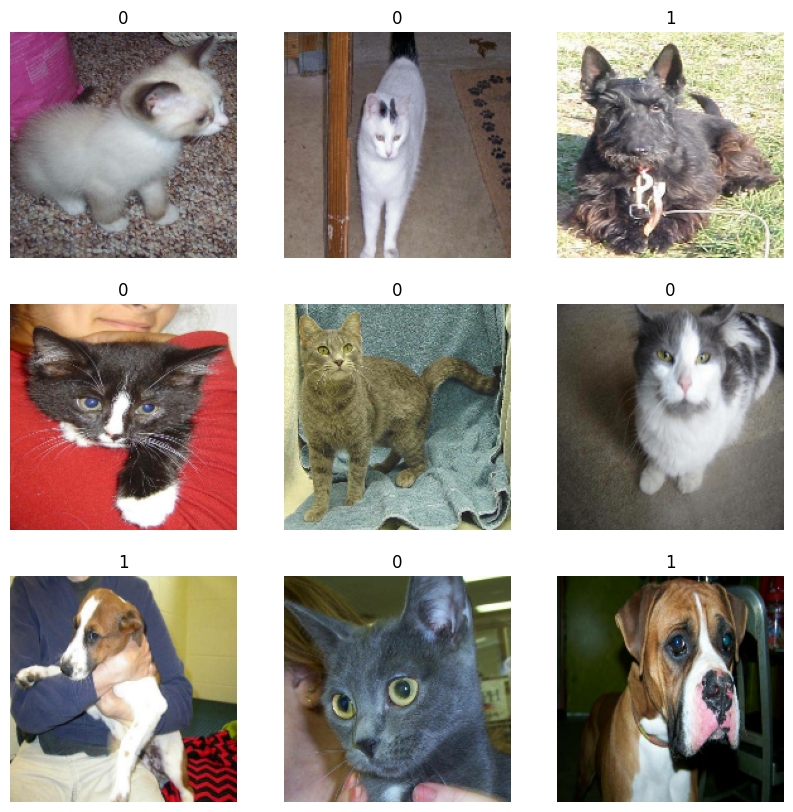

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Parte 4 - Aumento de datos

**4a)** Siguiendo con el ejemplo de keras, realizar aumento de datos a la primer imagen del dataset y mostrar los resultados.      
**4b)** Además de las opciones que se muestan el ejemplo ¿Qué otras opciones de aumento de datos brinda Keras? Muestre alguna que no aparezca en el ejemplo.      
**4c)** Asegúrese de entender por qué en algún caso puede tener sentido realizar el aumento de datos en el modelo y en otros sobre el dataset.  

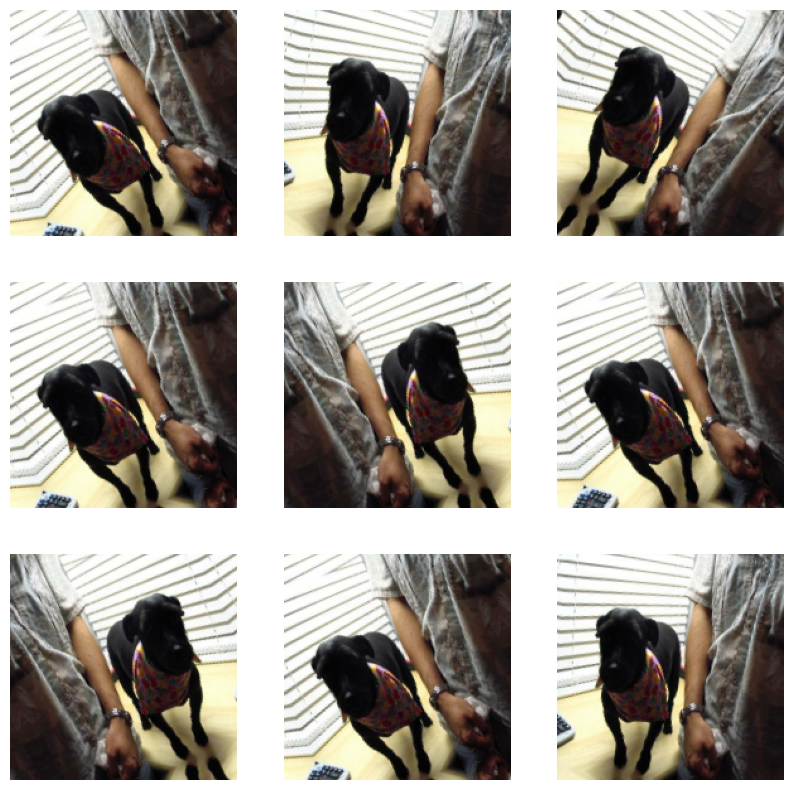

In [7]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

## Parte 5 - Entrenando con aumento de datos en el modelo

Copie el modelo del ejemplo y entrene durante 10 épocas utilizando dicho modelo.

**5a)** Asegúrese que entiende cómo fue construída la red y cada uno de los bloques que se utilizan      
**5b)** Modifique la salida de la red para que la salida tenga *num_classes* unidades independientemente de cuál sea el número de clases.         
**5c)** Entrene la red durante 10 épocas          

In [12]:
import tensorflow as tf
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [17]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    #x = data_augmentation(inputs)
    #x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)



Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/max_pooling2d_6/MaxPool' defined at (most recent call last):
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell
      result = self._run_cell(
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell
      result = runner(coro)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ureca\AppData\Local\Temp\ipykernel_8372\2746310097.py", line 11, in <module>
      model.fit(
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\layers\pooling\base_pooling2d.py", line 84, in call
      outputs = self.pool_function(
Node: 'model_2/max_pooling2d_6/MaxPool'
OOM when allocating tensor with shape[32,256,45,45] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/max_pooling2d_6/MaxPool}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_30944]

## Parte 6 - Utilizando Modelos Preentrenados

En esta parte en vez de entrenar un modelo desde cero vamos a utilizar un modelo preentrenado en otro problema y adaptarlo al de clasificar entre perros y gatos. Se evaluarán dos modelos: Resnet50 y Xception.

**6a)** Levantar ambos modelos con los pesos preentrenados con la base *Imagenet*. Ver un ejemplo en la sección *Using Pretrained Models from Keras* del *Capíítulo 14* del libro del curso.  
**6b)** Adaptar el ejemplo del libro para mostrar, para cada una de los modelos cargados, cuáles son las *top3* clases de un *batch* de imágenes del dataset de entrenamiento. ¿Qué observa?  

## Parte 7 - Visualización de filtros

En el caso del modelo *Resnet50* mostrar los filtros aprendidos en la primera capa de convolución. Explique con algún ejemplo por qué puede ser razonable utilizar estos mismos filtros en otro problema.

## Parte 8 - Transferencia de aprendizaje

Tomando como referencia la sección *Pretrained Models for Transfer Learning*  del *Capíítulo 14* del libro y el ejemplo [Transfer Learning](https://keras.io/guides/transfer_learning/) de keras, realizar transferencia de aprendizaje utilizando ambos modelos. 

## Parte 9 - Grad Cam

Una vez que se entrena una red convolucional es muy útil entender en qué basa la red sus predicciones. Uno de los métodos propuestos en ese sentido es [GradCAM](https://arxiv.org/pdf/1610.02391.pdf). 

**9a)** ¿Para qué puede ser útil un método que explique los resultados obtenidos?     
**9b)** Adaptar el [ejemplo](https://keras.io/examples/vision/grad_cam/) de keras y mostrar sobre algunas imágenes de validación las predicciones realizadas y los mapas de activación superpuestos a la imagen. Para eso utilizar (o adaptar) las funciones `make_gradcam_heatmap()` y `save_and_display_gradcam()`.

## Parte 10 - Evauar con el conjunto de Test

Evaluar el modelo con que haya obtenido mejores resultados con el conjunto de validación con el conjunto de test. En este taller el foco no está puesto en optimizar los clasificadores, sin embargo verifique que los resultados obtenidos con el conjunto de test son del orden de los obtenidos con el conjunto de valdiación.